In [ ]:
!pip install transformers datasets torch torchvision

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T, datasets
from transformers import ViTForImageClassification, TrainingArguments, Trainer, ViTImageProcessor
import matplotlib.pyplot as plt
import zipfile
import os


In [3]:
zip_file_path = 'archive1.zip'
extract_dir = 'brain_tumor_mri'


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Files extracted to:", extract_dir)


Files extracted to: brain_tumor_mri


In [4]:
model_name = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_name)

image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]


normalize = T.Normalize(mean=image_mean, std=image_std)

train_transforms = T.Compose([
    T.RandomResizedCrop(size),
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=30),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.ToTensor(),
    normalize
])


val_test_transforms = T.Compose([
    T.Resize(size),
    T.CenterCrop(size),
    T.ToTensor(),
    normalize
])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [5]:
# Load datasets
from torch.utils.data import DataLoader, ConcatDataset

train_dir = os.path.join(extract_dir, 'Training')
test_dir = os.path.join(extract_dir, 'Testing')
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)


print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')


Train dataset size: 5712
Test dataset size: 1311


In [6]:
id2label = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
label2id = {v: k for k, v in id2label.items()}


model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)


training_args = TrainingArguments(
    output_dir="vit-1",
    evaluation_strategy="steps",
    eval_steps=50,
    logging_steps=100,
    save_total_limit=2,
    learning_rate=5e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    fp16=True,
    fp16_full_eval=True,
    dataloader_num_workers=2,
    gradient_accumulation_steps=2,
    push_to_hub=False,
    logging_dir='./logs'
)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [7]:
def data_collator(features):
    images, labels = zip(*features)
    pixel_values = torch.stack(images)
    return {'pixel_values': pixel_values, 'labels': torch.tensor(labels)}


In [8]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}


In [9]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)




trainer.train()

eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

outputs = trainer.predict(test_dataset)
print("Test set metrics:")
print(outputs.metrics)

model.save_pretrained("vit-1")
processor.save_pretrained("vit-1")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Step,Training Loss,Validation Loss,Accuracy
50,No log,0.516468,0.846682
100,0.575300,0.337343,0.909992


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Evaluation results: {'eval_loss': 0.3034830391407013, 'eval_accuracy': 0.919908466819222, 'eval_runtime': 7.8288, 'eval_samples_per_second': 167.459, 'eval_steps_per_second': 5.237, 'epoch': 3.0}


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test set metrics:
{'test_loss': 0.3034830391407013, 'test_accuracy': 0.919908466819222, 'test_runtime': 5.9244, 'test_samples_per_second': 221.288, 'test_steps_per_second': 6.921}


['vit-1/preprocessor_config.json']

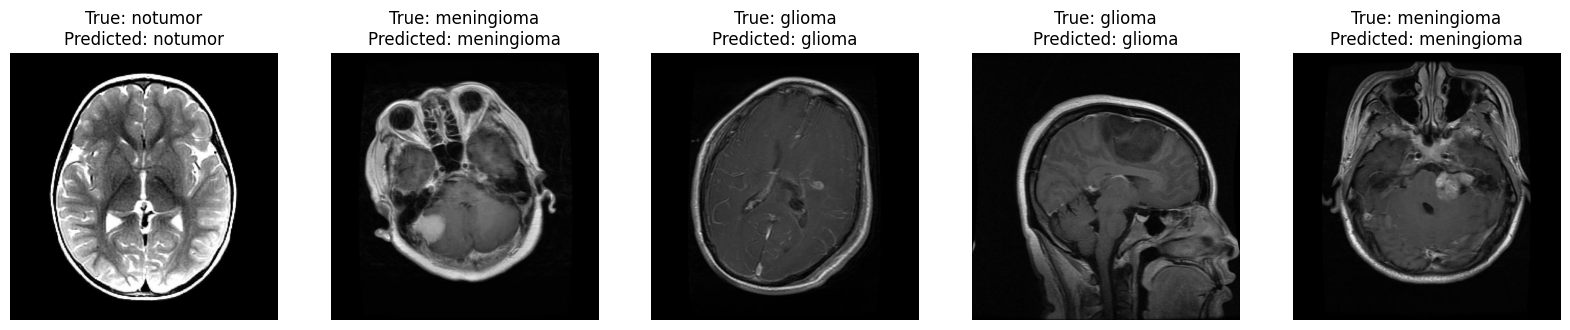

In [13]:
from PIL import Image
import random


test_dir = 'brain_tumor_mri/Testing'
num_images = 5


test_class_dirs = os.listdir(test_dir)
random_images = []

while len(random_images) < num_images:
    random_class = random.choice(test_class_dirs)
    random_image_name = random.choice(os.listdir(os.path.join(test_dir, random_class)))
    test_image_path = os.path.join(test_dir, random_class, random_image_name)
    random_images.append((test_image_path, random_class))


model = ViTForImageClassification.from_pretrained("vit-1")
processor = ViTImageProcessor.from_pretrained("vit-1")


fig, axs = plt.subplots(1, num_images, figsize=(20, 5))
for i, (image_path, true_label) in enumerate(random_images):
    test_image = Image.open(image_path).convert("RGB")
    inputs = processor(images=test_image, return_tensors="pt")

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=-1).item()

    predicted_label = id2label[predicted_class_id]

    axs[i].imshow(test_image)
    axs[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
    axs[i].axis('off')

plt.show()
